In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from enum import Enum
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv('../../data/CoV-AbDab_080224.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12918 entries, 0 to 12917
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Name                                  12918 non-null  object 
 1   Ab or Nb                              12918 non-null  object 
 2   Binds to                              12918 non-null  object 
 3   Doesn't Bind to                       3201 non-null   object 
 4   Neutralising Vs                       6373 non-null   object 
 5   Not Neutralising Vs                   5482 non-null   object 
 6   Protein + Epitope                     12914 non-null  object 
 7   Origin                                12913 non-null  object 
 8   VHorVHH                               12918 non-null  object 
 9   VL                                    12112 non-null  object 
 10  Heavy V Gene                          12918 non-null  object 
 11  Heavy J Gene   

In [10]:
df.describe()

,ABB Homology Model (if no structure)
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


# Data Definition

<center>
<img src="./media/Antibody_with_CDRs.svg.png" alt="drawing" width="200"/>
</center>

| Feature                       | What does it denote?              |
| ----------------------------- | ------------------------------------------------------------------------------------------|
| Name                          | Name of the antibody                                                                      |
| Ab or Nb                      | 'Ab' is standard Y shape antibodies, Nb is nanosized antibodies found in camels or llamas |
| 'Binds to'                    | Antibody is attached to Virus     |
| 'Doesn't Bind to'             | Antibody is NOT attached to Virus |
| 'Neutralising Vs'             | Antibody kills the Virus          |
| 'Not Neutralising Vs'         | Antibody does not kill the Virus  |
| Protein + Epitope             | Spike antibody responsible for entry of the virus, and part of the virus that the Human Immune System recognizes |
| Origin                        | Species or name of host it comes from |
| VH or VHH                     | Ends of the 
| VL                            | 
| Heavy V Gene                  | Part of the brute-force defense against the "zero-day exploits" of evolving viruses. This is to form the V-shape, and it provides the **primary** poking part of antibody |
| Heavy J Gene                  | Same as above ^^ "". This is to form the link of the V-shape of the antibody, and it provides the heavy lifting. |
| Light V Gene                  | Same as above ^^ "". This is to form the structural body of the antibody, and it provides the finetuning of poking into the virus. |
| Light J Gene                  | Same as above ^^ "". Again, links V-shape, but it does the fine tuning part.
| CDRH3                         | The physical key that does the heavy attachment to the antigen of the virus.
| CDRL3                         | The physical key that does the light fine-tuning attachment to the antigen of the virus
| Structures                    | These are 3D Coordinate Data, not necessary

<center>
<img src="./media/figure-2-vhh-covid.jpg" alt="drawing" width=200 />
</center>


# Data Cleaning

In [ ]:
df = df[df['CDRH3'].notna() & (df['CDRH3'] != 'ND')]

In [12]:
def split_row(row):
    return row.split(';') if isinstance(row, str) else []

class label_class(Enum):
    BINDS_TO = (0, 'Binds to')
    NOT_BINDS_TO = (1, 'Doesn\'t Bind to')
    NEUTRALISING_TO = (2, 'Neutralising Vs')
    NOT_NEUTRALISING_TO = (3, 'Not Neutralising Vs')

class count_strands():
    def __init__(self, df: pd.DataFrame) -> None:
        self.label_classes_arr = [label_class_nth.value[1] for label_class_nth in label_class]
        self.label_count = [self.class_count(i, df) for i in self.label_classes_arr]

    def class_count(self, classname: str, df: pd.DataFrame):
        unique_count = {}
        binding_classes = df[classname].apply(split_row)

        for array_row in binding_classes:
            for strand in array_row:
                strand = strand.removeprefix('SARS-CoV2_').removesuffix('(weak)').strip()
                unique_count[strand] = (unique_count[strand] if strand in unique_count else 0) + 1
        return list(dict(sorted(unique_count.items(), key=lambda item: item[1], reverse=True)).items())
    
    def plot_classes(self, label_class_chosen: label_class, k=10):
        plot_x_classes: list[str] = [ith[0] for ith in self.label_count[label_class_chosen.value[0]]][:k]
        plot_y_values = [ith[1] for ith in self.label_count[label_class_chosen.value[0]]][:k]
        plt.bar(x=plot_x_classes, height=plot_y_values)
        plt.xticks(plot_x_classes, ha='right', rotation=45)
        plt.show()
    
count_strands_article = count_strands(df)

In [ ]:
def label_neutralization(row):
    if pd.notna(row['Neutralising Vs']) and row['Neutralising Vs'] != '' and 'SARS-CoV2_WT' in row['Neutralising Vs']:
        return 1
    elif pd.notna(row['Not Neutralising Vs']) and row['Not Neutralising Vs'] != '' and 'SARS-CoV2_WT' in row['Not Neutralising Vs']:
        return 0
    else:
        return 0

df['is_neutralizing'] = df.apply(label_neutralization, axis=1)

# 2. Simple Feature Engineering on CDRH3
# Drop rows where CDRH3 is missing
df = df[df['CDRH3'].notna() & (df['CDRH3'] != 'ND')]

# Feature 1: Length
df['cdr3_len'] = df['CDRH3'].apply(len)

# Feature 2: Basic Amino Acid Counts (AAC)
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
for aa in amino_acids:
    df[f'amino_acid_percentage_{aa}'] = df['CDRH3'].apply(lambda x: x.count(aa) / len(x))

df

              precision    recall  f1-score   support

           0       0.65      0.82      0.73      1444
           1       0.66      0.44      0.53      1138

    accuracy                           0.65      2582
   macro avg       0.65      0.63      0.63      2582
weighted avg       0.65      0.65      0.64      2582



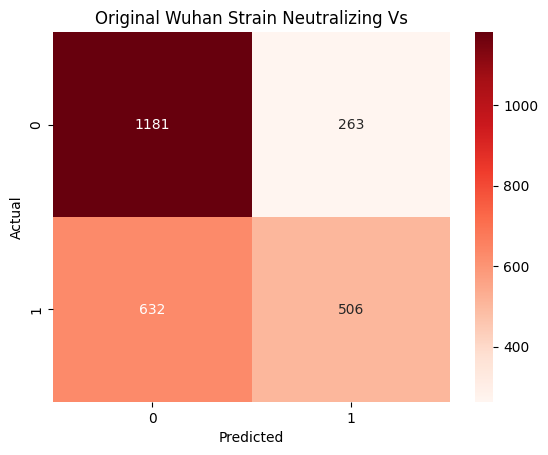